<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 4 / SPRINT 2 / NOTE 1*

# 📝 Assignment

---


# Count-based_Representation

indeed.com 에서 Data Scientist 키워드로 Job descrition을 찾아 스크래핑한 데이터를 이용해 과제를 진행해 보겠습니다.

[Data_Scienties.csv](https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv) 파일에는 1300여개의 Data Scientist job description 정보가 담겨 있습니다.

## 1. 데이터 전처리 (Text preprocessing)

In [75]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0) 텍스트 분석에 앞서 데이터 전처리를 진행합니다.

- 파일을 불러온 후 title, company, description 에 해당하는 Column만 남겨주세요.
- 중복값을 제거하세요.

In [76]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv')

In [77]:
df = df[['title', 'company', 'description']]
df = df.drop_duplicates()

df.head()

,title,company,description
0,Data Scientist (Structured Products),EquiTrust Life Insurance Company,Job Details\nDescription\nEssential Duties and...
2,"Specialist, Data Science",Nationwide,As a team member in the Finance and Internal A...
4,Sr. Data Scientist (Remote),American Credit Acceptance,Overview:\nAmerican Credit Acceptance seeks a ...
5,Data Scientist Associate Sr (DADS06) BTB - LEG...,"JPMorgan Chase Bank, N.A.",J.P. Morgan's Corporate & Investment Bank (CIB...
6,Data Scientist,VyStar Credit Union,"At VyStar, we offer competitive pay, an excell..."


In [78]:
df.shape

(757, 3)

### 1) 토큰을 정제합니다.

- 문자를 소문자로 통일
- 분석에 관련 없는 정보 제거
- 이번 과제는 `spacy` 로부터 `"en_core_web_sm"` 을 로드하여 진행해주세요.

- **문항 1) 대문자를 소문자로 변경하는 함수를 입력하세요.**
- **문항 2) 정규 표현식을 사용하여 re 라이브러리에서 알파벳 소문자, 숫자만 받을 수 있는 코드를 작성하세요.**

In [79]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [80]:
# 대문자 -> 소문자, \n처리
for column in df:
  df[column] = df[column].apply(lambda x:x.lower())
  df[column] = df[column].apply(lambda x:x.replace('\n', ' '))
  df[column] = df[column].apply(lambda x:x.replace('  ', ' '))

In [81]:
# 정규표현식
def tokenize(column):
  tokens = []

  for doc in tokenizer.pipe(df[column]):
      doc_tokens = [re.sub(r"[^a-z0-9 ]", "", token.text.lower()) for token in doc]
      tokens.append(doc_tokens)
  
  return tokens

df['titletokens'] = tokenize('title')
df['tcompanytokens'] = tokenize('company')
df['descriptiontokens'] = tokenize('description')

df.tail(1)

,title,company,description,titletokens,tcompanytokens,descriptiontokens
1299,senior data scientist,spring discovery,tl;dr spring is accelerating the discovery of ...,"[senior, data, scientist]","[spring, discovery]","[tldr, spring, is, accelerating, the, discover..."


### 2) 정제한 토큰을 시각화 합니다.

- Top 10 토큰을 프린트 합니다.
- 토큰의 수, 빈도 순위, 존재 문서 수, 비율 등 정보를 계산합니다.
- 토큰 순위에 따른 퍼센트 누적 분포 그래프를 시각화합니다.

- **문항 3) 추천 토큰 순위 10개 단어를 입력하세요.**

In [82]:
from collections import Counter

def word_count(docs):
  word_counts = Counter()
  word_in_docs = Counter()

  total_docs = len(docs)

  for doc in docs:
    word_counts.update(doc)
    word_in_docs.update(set(doc))

  temp = zip(word_counts.keys(), word_counts.values())

  wc = pd.DataFrame(temp, columns=['word', 'count'])

  wc['rank'] = wc['count'].rank(method='first', ascending=False)
  total = wc['count'].sum()

  wc['percent'] = wc['count'].apply(lambda x: x / total)

  wc = wc.sort_values(by='rank')

  wc['cul_percent'] = wc['percent'].cumsum()

  temp2 = zip(word_in_docs.keys(), word_in_docs.values())
  ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
  wc = ac.merge(wc, on='word')

  wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

  return wc.sort_values(by='rank')

In [83]:
wc = word_count(df['descriptiontokens'])
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
19,and,755,21864,1.0,0.056118,0.056118,0.997358
171,to,754,12694,2.0,0.032581,0.088699,0.996037
116,the,745,10538,3.0,0.027048,0.115747,0.984148
24,of,745,8839,4.0,0.022687,0.138433,0.984148
214,data,740,7425,5.0,0.019058,0.157491,0.977543


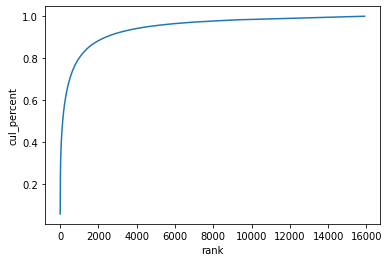

In [84]:
import seaborn as sns

sns.lineplot(x='rank', y='cul_percent', data=wc)

In [85]:
wc['word'][:10]

19      and
171      to
116     the
24       of
214    data
174      in
223       a
77     with
353     for
75       or
Name: word, dtype: object

### 4) 확장된 불용어 사전을 사용해 토큰을 정제합니다.


- **문항 4) 기본 불용어 사전에 두 단어(`"data", "work"`)를 추가하는 코드를 사용해주세요.**
- **문항 5) 불용어를 제거하고 난 뒤 토큰 순위 10개의 단어를 입력하세요.**

In [86]:
STOP_WORDS = nlp.Defaults.stop_words.union(['data', 'work'])

In [90]:
tokens = []

for doc in tokenizer.pipe(df['description']):
  doc_tokens = []

  for token in doc:
    if (token.is_stop == False) & (token.is_punct == False):
      if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())
  
  tokens.append(doc_tokens)

df['descriptiontokens2'] = tokens

In [91]:
wc2 = word_count(df['descriptiontokens2'])
wc2['word'][:10]

14      experience
341       business
64            team
264       learning
383        machine
685        science
129        ability
103       analysis
520    statistical
215         skills
Name: word, dtype: object

### 5) Lemmatization 사용 효과를 분석해 봅니다.



- **문항 6) Lemmatization을 진행한 뒤 상위 10개 단어를 입력하세요.**

In [93]:
def get_lemmas(text):

  lemmas = []

  doc = nlp(text)

  for token in doc:
    if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
      lemmas.append(token.lemma_)
    
  return lemmas

df['lemmas'] = df['description'].apply(get_lemmas)
df['lemmas'].head()

0    [job, detail, description, essential, duty, re...
2    [team, member, finance, internal, audit, depar...
4    [overview, american, credit, acceptance, seek,...
5    [j.p, morgan, corporate, investment, bank, cib...
6    [vystar, offer, competitive, pay, excellent, b...
Name: lemmas, dtype: object

In [94]:
wc3 = word_count(df['lemmas'])
wc3['word'][:10]

34          datum
8      experience
66           work
52           team
185          data
285      business
120       science
89       analysis
150         model
433      analytic
Name: word, dtype: object

## 2. 유사한 문서 찾기

### 1) `TfidfVectorizer`를 이용해 각 문서들을 벡터화 한 후 KNN 모델을 만들고, <br/> 내가 원하는 `job description`을 질의해 가장 가까운 검색 결과들을 가져오고 분석합니다.

- **문항 9) 88번 index의 `job description`와 5개의 가장 유사한 `job description`이 있는 index를 입력하세요.**
    - 답은 88번 인덱스를 포함합니다.
    - `max_features = 3000` 으로 설정합니다.
    - [88, 90, 91, 93, 94] 형태로 답을 입력해주세요

In [96]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

dtm_tfidf = tfidf.fit_transform(df['description'])
dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf.get_feature_names())
dtm_tfidf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,10,100,11,12,14,15,18,19,20,200,2017,2018,2019,2020,22,24,25,30,300,31,35,3m,40,400,401,401k,50,500,5000,60,600,75,80,90,aa,ab,abilities,ability,...,wellness,whip,wholly,wi,wide,widely,wildlife,willing,willingness,winning,women,word,work,workday,worked,worker,workers,workflow,workflows,workforce,working,workplace,workplaces,works,world,worldwide,wrangling,wri,write,writing,written,www,year,years,yelp,yes,york,yrs,zillow,zulily
0,0.0,0.000000,0.05272,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058637,0.052353,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.069356,0.0,0.0,0.000000,0.062315,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.051677,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.023379,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.072438,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.031375,0.027418,0.0,0.0,0.000000,0.098541,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.071503,0.0,0.0,0.000000,0.012252,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.018485,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056214,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.058743,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.062152,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.05851,0.0,0.000000,0.017488,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.033337,0.00000,0.035082,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.042929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043708,...,0.0,0.0,0.0,0.0,0.053924,0.0,0.0,0.000000,0.038602,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038116,0.000000,0.0,0.0,0.030795,0.103499,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.060084,0.013012,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027691,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030387,0.0,0.0,0.0,0.0,0.0,0.0,0.030644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023711,0.010585,...,0.0,0.0,0.0,0.0,0.019588,0.0,0.0,0.000000,0.000000,0.0,0.0,0.028417,0.067195,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020896,0.0,0.0,0.044746,0.000000,0.0,0.0,0.0,0.0,0.021826,0.00000,0.0,0.000000,0.047268,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm_tfidf)

NearestNeighbors(algorithm='kd_tree')

In [99]:
nn.kneighbors([dtm_tfidf.iloc[88]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


(array([[0.        , 1.1283426 , 1.18893646, 1.19442548, 1.19937307]]),
 array([[ 88,  40, 121,  68, 680]]))

## 3. TF-IDF 이용한 텍스트 분류 진행하기

TF-IDF를 이용해 문장 혹은 문서를 벡터화한 경우, 이 벡터값을 이용해 문서 분류 태스크를 진행할 수 있습니다. 

현재 다루고 있는 데이터셋에는 label이 존재하지 않으므로, title 컬럼에 "Senior"가 있는지 없는지 여부를 통해 Senior 직무 여부를 분류하는 작업을 진행해보겠습니다.

### 1) title 컬럼에 "Senior" 문자열이 있으면 1, 없으면 0인 "Senior"라는 새로운 컬럼을 생성해주세요.

문항 7) 새롭게 만든 Senior 컬럼에서 값이 1인 (Senior O) 데이터의 개수는?

In [107]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv')
df = df[['title', 'company', 'description']]
df = df.drop_duplicates()

In [108]:
df['senior'] = df['title'].apply(lambda x: 1 if 'Senior' in x else 0)

In [110]:
df['senior'].sum()

95

문항 8) sklearn의 `train_test_split`을 통해 train 데이터와 valid 데이터로 나눈 후, `sklearn`의 `DecisionTreeClassifier`를 이용해 분류를 진행해주세요. 

단, x값은 위에서 학습한 dtm_tfidf를 그대로 이용해주세요. train_test_split과 DecisionTreeClassifier의 random_state을 42로 고정하고, test_size는 0.1로 설정해주세요.

학습을 완료한 후, test 데이터에 대한 예측을 진행하고 label 1에 대한 precision과 recall 값을 적어주세요

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(dtm_tfidf, df['senior'], random_state=42, test_size=0.1, stratify=df['senior'])

In [121]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        66
           1       0.15      0.20      0.17        10

    accuracy                           0.75        76
   macro avg       0.51      0.52      0.51        76
weighted avg       0.78      0.75      0.76        76

